# Extract profiles for all proplyds and all filters

## Library imports

### General libraries

In [1]:
import numpy as np 
from pathlib import Path
import pandas as pd

### Astronomy libraries

In [2]:
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, QTable
from astropy.nddata import Cutout2D
import regions

### Graphics libraries

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
sns.set_context("talk")
sns.set_color_codes()

## Paths to the data files

In [5]:
datapath = Path.cwd().parent / "data"

## Get all the images we need in various filters

In [6]:
pcfilters = ["f631n", "f673n", "f656n", "f658n", "f547m", ]

In [7]:
class FilterImage:
    """WFPC2 PC image in a given filter
    
    Includes the following attributes:
    
    name: name of filter
    data: pixel image (hi-pass filtered)
    sdata: pixel image (lo-pass filtered)
    coords: celestial coordinates of pixels (same shape as data)
    wcs: an astropy.wcs.WCS instance
    """
    def __init__(self, name):
        self.name = name
        hdu = fits.open(
            datapath / f"align-pcmos-{self.name}_sharp_16.fits"
        )[0]
        self.wcs = WCS(hdu.header)
        self.data = hdu.data
        self.sdata = fits.open(
            datapath / f"pcmos-{self.name}_smooth_16.fits"
        )[0].data
        ny, nx = self.data.shape
        self.coords = self.wcs.pixel_to_world(
            *np.meshgrid(np.arange(nx), np.arange(ny))
        )

In [8]:
imdict = {
    name: FilterImage(name) for name in pcfilters
}

a floating-point value was expected. [astropy.wcs.wcs]
Changed DATE-OBS from '21/03/95          ' to '1995-03-21''. [astropy.wcs.wcs]


## Get all the proplyd source coordinates

Get the sources from the DS9 region file that I made by hand.

In [344]:
regfile = datapath / "pcmos-proplyds.reg"
regs = regions.Regions.read(regfile, format="ds9")

Use θ¹ Ori C as origin to define position angles.

In [345]:
c0 = SkyCoord.from_name("* tet01 Ori C")

Extract the information that we want from the region file. Construct a list of dicts that give source name and coordinates:

In [346]:
source_list = [
    {"Name": r.meta["label"],  "ICRS": r.center} 
    for r in regs 
    if "label" in r.meta
]

Convert to an `astropy.table.QTable` of the sources. Add columns for PA to θ¹ Ori C (in degrees) and Separation from θ¹ Ori C (in arcsec):

In [347]:
source_table = QTable(source_list)
source_table["PA"] = source_table["ICRS"].position_angle(c0).to(u.deg)
source_table["Sep"] = source_table["ICRS"].separation(c0).to(u.arcsec)
source_table.add_index("Name")
source_table

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
177-341W,"83.82363499999998,-5.394699444444445",314.98007715439655,25.432600010148143
173-341,"83.82216999999999,-5.394805277777778",325.2426367253809,22.345344070016168
170-337,"83.82073833333331,-5.3936150000000005",331.6047988646121,15.998131078035563
171-340,"83.82105708333333,-5.394350833333334",332.3781956253825,18.873422933876565
180-331,"83.82514916666666,-5.391885555555556",288.5266971454808,24.69660035312236
176-325,"83.82314416666665,-5.390236111111111",276.7092718655323,16.342545948543982
168-326,"83.82017499999999,-5.390600555555556",299.9587078190999,6.4508070307303065
161-328,"83.81696666666664,-5.391016944444445",51.38552690888274,7.563771376918397


By turning the `Name` column into an index, we can extract a given source by name. For example:

In [348]:
source_table.loc["182-413"]

Name,ICRS,PA,Sep
,"deg,deg",deg,arcsec
str11,SkyCoord,float64,float64
182-413,"83.82584708333331,-5.403739722222222",332.8419926483634,56.78242731489862


The advantage of using a `QTable` is that the units remain attached to the values:

In [349]:
source_table.loc["177-341W"]["PA"], source_table.loc["180-331"]["Sep"]

(<Angle 314.98007715 deg>, <Angle 24.69660035 arcsec>)

## Cutout image of a proplyd in a particular filter

We use `astropy.nddata.Cutout2D` to make cutouts of the sharp image, the smooth image, and the coordinate array. 

In [350]:
class ProplydCutout:
    
    def __init__(self, pdata, image: FilterImage, size=2 * u.arcsec):
        self.center = pdata["ICRS"]
        self.pa_star = pdata["PA"]
        self.sep = pdata["Sep"]
        self.pname = pdata["Name"]
        self.fname = image.name
        self.size = size
        self.cutout = Cutout2D(
            image.data, position=self.center, size=size, wcs=image.wcs, copy=True,
        )
        self.image = self.cutout.data
        self.wcs = self.cutout.wcs
        # Use the slices from this cutout to also get cutout of the smoothed data array
        self.smooth_image = image.sdata[self.cutout.slices_original]
        # ... and the same for the coordinates
        self.image_coords = image.coords[self.cutout.slices_original]
        # Radius and PA of each pixel with respect to the center
        self.r = self.center.separation(self.image_coords)
        self.pa = self.center.position_angle(self.image_coords)
        # Default mask has max radius of half the cutout size
        self.set_mask(r_out=self.size / 2)
        self.owcs = self.get_ortho_wcs()
        
    def __repr__(self):
        return f"ProplydCutout({self.pname}, {self.fname})"
       
    def get_ortho_wcs(self):
        """Auxilary WCS that is orthogonal to RA, Dec
        
        Pixel size is 1 arcsec. 
        Origin is set at corner pixel, 
        which is (1, 1) in FITS, but is (0, 0) in python
        """
        wcs = WCS(naxis=2)
        wcs.wcs.cdelt = [-1/3600, 1/3600]
        wcs.wcs.crval = [self.center.ra.deg, self.center.dec.deg]
        wcs.wcs.crpix = [1, 1]
        wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        return wcs
         
    def set_mask(
        self,
        r_out = 1.0 * u.arcsec,
        r_in = 0.1 * u.arcsec,
        mu_min = -0.0,
    ):
        cth = np.cos((self.pa - self.pa_star))
        self.mask = (self.r <= r_out) & ((cth >= mu_min) | (self.r <= r_in))

Test that the cutout works:

In [351]:
p = ProplydCutout(source_table.loc["177-341W"], imdict["f547m"])

We can plot it with imshow, but that is rotated with respect to equatorial axes.

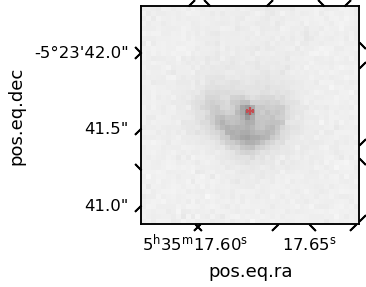

In [352]:
fig, ax = plt.subplots(subplot_kw=dict(projection=p.wcs))
ax.imshow(p.image, vmin=0, vmax=15, cmap="gray_r")
ax.scatter(
    p.center.ra.deg, 
    p.center.dec.deg, 
    transform=ax.get_transform("world"), 
    color='r', 
    marker="+",
    s=50,
)
...;

We can use the orthogonal wcs and pcolormesh to rotate the image so that axes are aligned with RA and Dec.

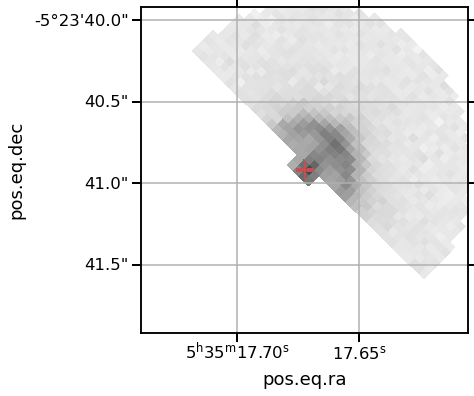

In [353]:
fig, ax = plt.subplots(
    figsize=(6, 6),
    subplot_kw=dict(projection=p.owcs),
)
T = ax.get_transform("world")
ax.pcolormesh(
    p.image_coords.ra.deg,
    p.image_coords.dec.deg,
    np.where(p.mask, p.image, np.nan), 
    vmin=0, 
    vmax=10, 
    cmap="gray_r",
    shading="nearest",
    transform=T,
)
ax.scatter(
    p.center.ra.deg, 
    p.center.dec.deg, 
    transform=T, 
    color='r', 
    marker="+",
    s=300,
)
ax.set_aspect("equal")
ax.set(
    xlim=[-1, 1],
    ylim=[-1, 1],
)
...;

In [354]:
j, i = np.unravel_index(np.argmin(p.r, axis=None), p.r.shape)
p.r[j, i].arcsec

0.02206657502623554

## Make cutout for all proplyds and all filters

Add them in to the table of sources

In [355]:
for fname in pcfilters:
    source_table[fname] = [ProplydCutout(row, imdict[fname]) for row in source_table]

In [356]:
source_table[pcfilters]

f631n,f673n,f656n,f658n,f547m
object,object,object,object,object
"ProplydCutout(177-341W, f631n)","ProplydCutout(177-341W, f673n)","ProplydCutout(177-341W, f656n)","ProplydCutout(177-341W, f658n)","ProplydCutout(177-341W, f547m)"
"ProplydCutout(173-341, f631n)","ProplydCutout(173-341, f673n)","ProplydCutout(173-341, f656n)","ProplydCutout(173-341, f658n)","ProplydCutout(173-341, f547m)"
"ProplydCutout(170-337, f631n)","ProplydCutout(170-337, f673n)","ProplydCutout(170-337, f656n)","ProplydCutout(170-337, f658n)","ProplydCutout(170-337, f547m)"
"ProplydCutout(171-340, f631n)","ProplydCutout(171-340, f673n)","ProplydCutout(171-340, f656n)","ProplydCutout(171-340, f658n)","ProplydCutout(171-340, f547m)"
"ProplydCutout(180-331, f631n)","ProplydCutout(180-331, f673n)","ProplydCutout(180-331, f656n)","ProplydCutout(180-331, f658n)","ProplydCutout(180-331, f547m)"
"ProplydCutout(176-325, f631n)","ProplydCutout(176-325, f673n)","ProplydCutout(176-325, f656n)","ProplydCutout(176-325, f658n)","ProplydCutout(176-325, f547m)"
"ProplydCutout(168-326, f631n)","ProplydCutout(168-326, f673n)","ProplydCutout(168-326, f656n)","ProplydCutout(168-326, f658n)","ProplydCutout(168-326, f547m)"
"ProplydCutout(161-328, f631n)","ProplydCutout(161-328, f673n)","ProplydCutout(161-328, f656n)","ProplydCutout(161-328, f658n)","ProplydCutout(161-328, f547m)"
"ProplydCutout(158-327, f631n)","ProplydCutout(158-327, f673n)","ProplydCutout(158-327, f656n)","ProplydCutout(158-327, f658n)","ProplydCutout(158-327, f547m)"


## Do the images

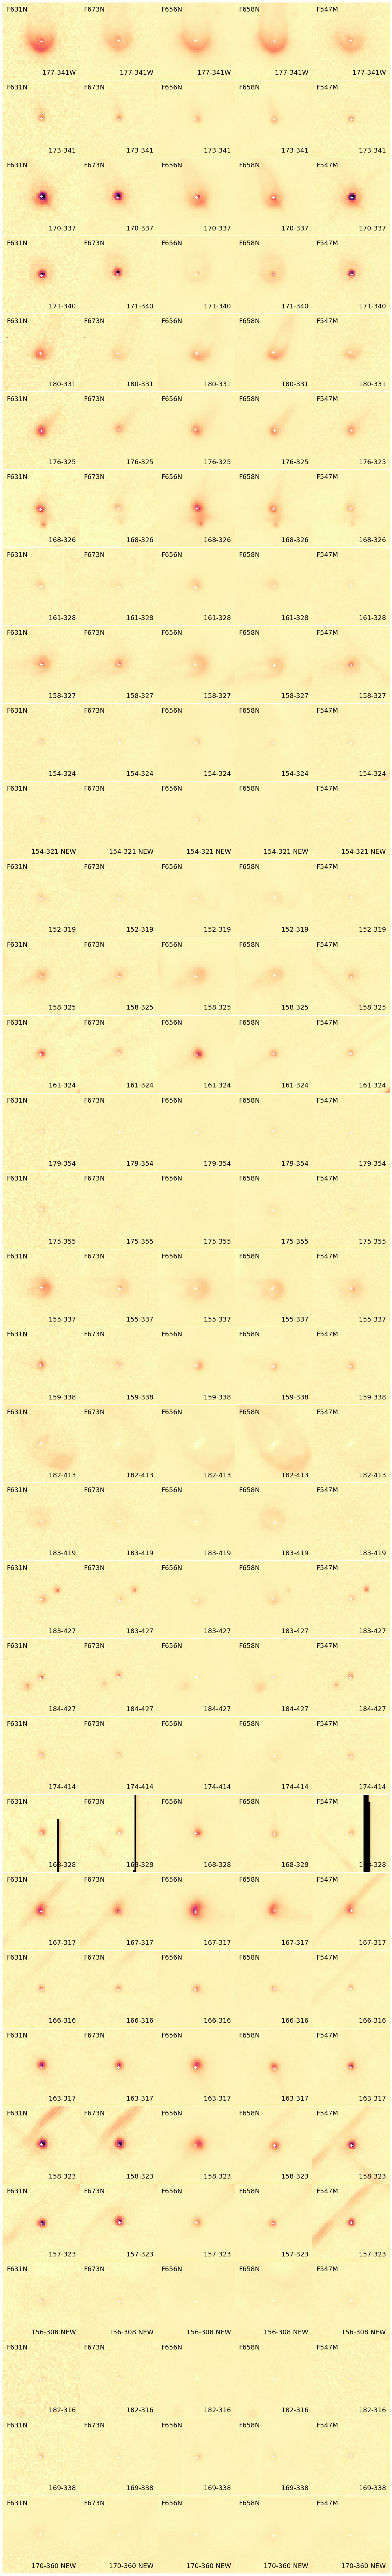

In [357]:
nprops = len(source_table)
ns = len(pcfilters)
fig, axes = plt.subplots(nprops, ns, figsize=(3 * ns, 3 * nprops))
for j, row in enumerate(source_table):
    for i, fname in enumerate(pcfilters):
        ax = axes[j, i]
        ax.imshow(row[fname].image**0.5, vmin=0.8, vmax=10, cmap="magma_r", origin='lower')
        ax.text(0.05, 0.95, fname.upper(), transform=ax.transAxes, va="top", ha="left")
        ax.text(0.95, 0.05, row["Name"], transform=ax.transAxes, va="bottom", ha="right")
        p = row[fname]
        xp, yp = p.center.to_pixel(p.wcs)
        ax.scatter(xp, yp, color="w", marker="+", s=50)
        j0, i0 = np.unravel_index(np.argmin(p.r, axis=None), p.r.shape)
        #ax.scatter(i0, j0, color="g", marker="x", s=50)
        ax.set(xticks=[], yticks=[])
sns.despine(left=True, bottom=True)
fig.tight_layout(pad=0, h_pad=0.1, w_pad=0.1)

## Do the profiles

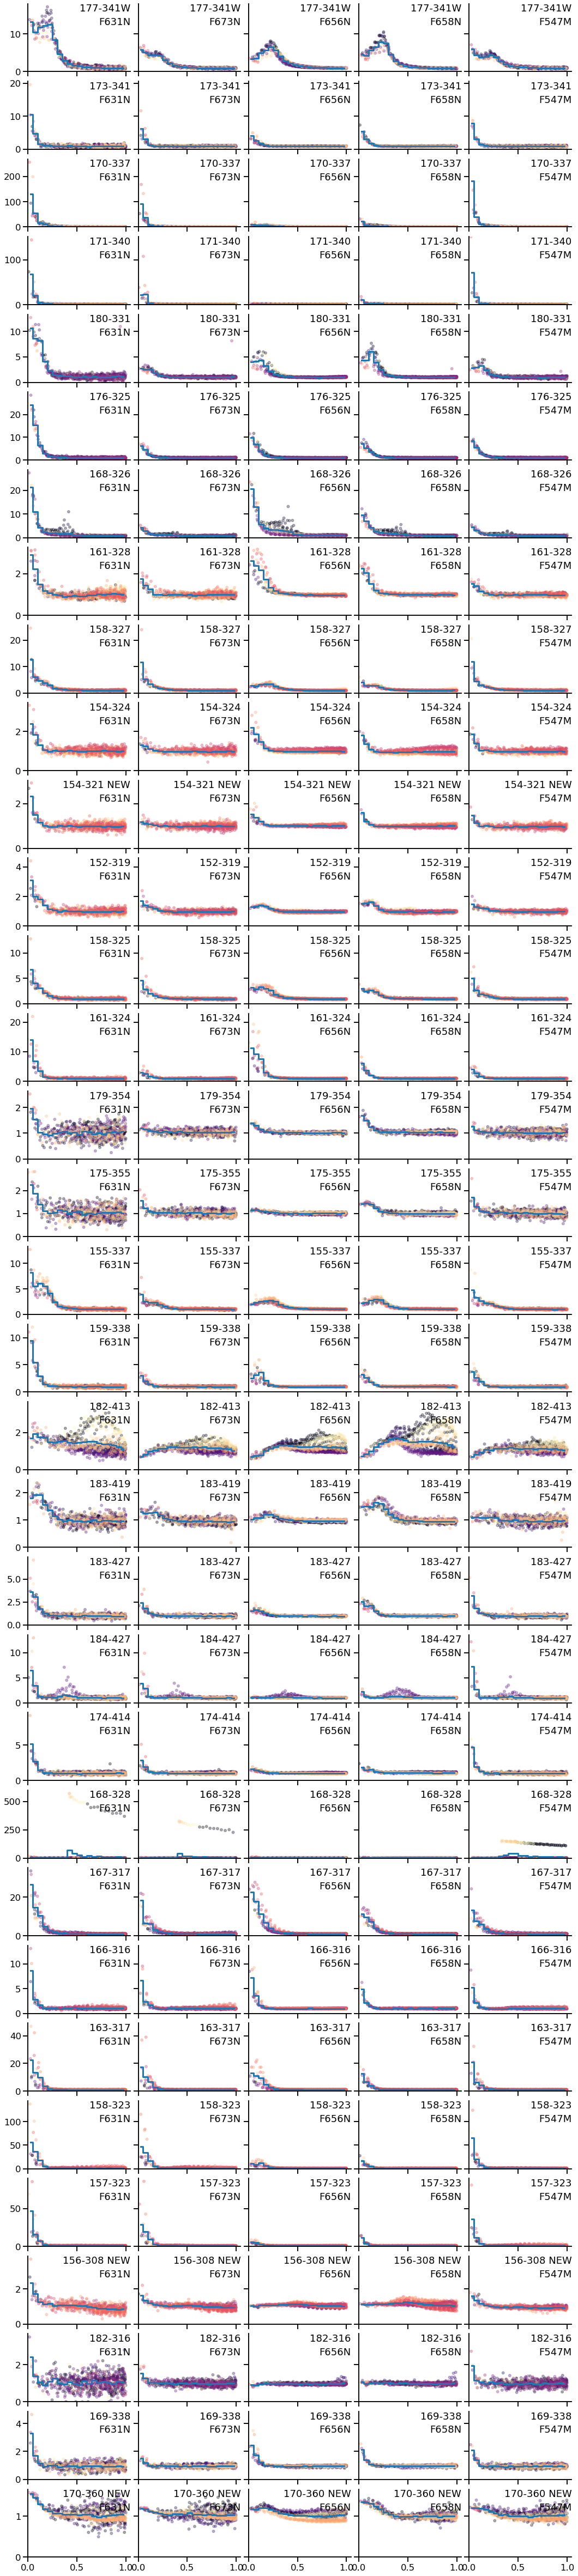

In [358]:
nbins = 20
fig, axes = plt.subplots(nprops, ns, figsize=(3 * ns, 2.0 * nprops), sharex=True, sharey='row')
for j, row in enumerate(source_table):
    for i, fname in enumerate(pcfilters):
        p = row[fname]
        ax = axes[j, i]
        m = p.mask
        ax.scatter(
            p.r.arcsec[m], p.image[m],
            c=(p.pa - p.pa_star)[m],
            alpha=0.3,
            cmap="magma_r",
            s=20,
        )
        h1, edges = np.histogram(p.r.arcsec[m], range=[0.0, 1.0], bins=nbins, weights=p.image[m])
        h0, edges = np.histogram(p.r.arcsec[m], range=[0.0, 1.0], bins=nbins)
        rgrid = 0.5 * (edges[1:] + edges[:-1])
        ax.plot(rgrid, h1 / h0, drawstyle="steps-mid", linewidth=3)
        ax.text(1.0, 0.8, fname.upper(), transform=ax.transAxes, va="top", ha="right")
        ax.text(1.0, 1.0, row["Name"], transform=ax.transAxes, va="top", ha="right")
        ax.set(ylim=[0.0, None], xlim=[0.0, None])
sns.despine()
fig.tight_layout(h_pad=0.3, w_pad=0.3)

I have made sure that all the profiles in the same row share a common y scale, so that we can easily compare the different profiles. 

We can see that in many cases the 631 profile is significantly higher than the sum of the 547 and the 656.  This is good evidence that we are seeing [O I] from the neutral disk wind. 

Not all sources show this however. For instance, 167-317 is pretty dominated by Ha.

We have also added a spatial averaging of the profiles, calculated using a weighted histogram. This is devloped further in the following section. 

## Put all the profiles on a common uniform grid of radii

Test method for determining bin edges that is robust to rounding errors:

In [359]:
bin_size = 0.05
epsilon = 0.01 # Fake rounding error
rmin = 0.0 + epsilon
rmax = 1.0 - epsilon

nbins = int(np.round((rmax - rmin) / bin_size))
edges = np.arange(nbins + 1) * bin_size
edges

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [360]:
class ProplydProfiles:
    """
    Radial profiles of proplyd brightness for multiple filters
    
    All interpolated onto a common grid of radial points
    """
    bin_size = 0.05
    
    def __init__(self, data, fnames):
        # Setup the radial bins
        rmax = data["f631n"].size.to(u.arcsec).value / 2
        rmin = 0.0
        nbins = int(np.round((rmax - rmin) / bin_size))
        edges = np.arange(nbins + 1) * bin_size
        # Convert to cell centers
        self.r = 0.5 * (edges[1:] + edges[:-1])
        # Initialize Tables to hold results
        self.mean = Table({"r": self.r})
        self.sigma = Table({"r": self.r})
        self.npix = Table({"r": self.r})
        # Copy some metadata from the proplyd
        self.name = data["Name"]
        # Initialise dicts to hold the smooth BG mean and sigma
        self.bgmean = {}
        self.bgsig = {}
        # Process each filter
        for fname in fnames:
            p = data[fname]
            m = p.mask
            # Use weighted histograms to get mean and stddev
            h1, _ = np.histogram(
                p.r.arcsec[m], 
                range=[rmin, rmax], 
                bins=edges, 
                weights=p.image[m],
            )
            h0, _ = np.histogram(
                p.r.arcsec[m], 
                range=[rmin, rmax], 
                bins=edges, 
                weights=None,
            )
            h2, _ = np.histogram(
                p.r.arcsec[m], 
                range=[rmin, rmax], 
                bins=edges, 
                weights=p.image[m]**2,
            )
            # Number of image pixels that contribute to each radial bin
            self.npix[fname] = h0
            # Mean brightness in each radial bin
            self.mean[fname] = h1 / h0
            # Standard deviation of brightness in each radial bin
            self.sigma[fname] = np.sqrt((h2 / h0) - (h1 / h0)**2)
            # Also save smooth BG values
            self.bgmean[fname] = np.mean(p.smooth_image)
            self.bgsig[fname] = np.std(p.smooth_image)            

            

        

        

In [361]:
pp = ProplydProfiles(source_table.loc["177-341W"], pcfilters)

In [362]:
pp.mean

r,f631n,f673n,f656n,f658n,f547m
float64,float64,float64,float64,float64,float64
0.025,13.149402239247323,5.841245601033858,3.4430602799551284,4.541379548833063,5.94089322196268
0.07500000000000001,10.463109260430718,5.073563249354721,3.599493791542092,4.229190169915672,4.468202735302857
0.125,11.731134793139482,4.334691236376098,4.9199929911461995,5.651517809816017,3.846224242597191
0.17500000000000002,12.258012098032172,4.442916610154252,5.755757001734613,6.511599754554721,4.021727578770452
0.225,12.528806980574435,4.294906447490237,6.589078763256031,7.929133909421463,4.436882438704776
0.275,8.423511908663452,3.1439707401222248,5.659097379741993,7.6025182186810385,3.846756957662999
0.32500000000000007,4.628567066696915,2.192826274138788,4.05240306895638,4.599773922448323,2.7760171288173137
0.375,2.965407737729004,1.6290935718619741,2.8697082168861767,2.7657151782307796,1.904050516912374
0.42500000000000004,2.0166813087975015,1.3790769124898947,2.1664471121141435,1.8704060176163075,1.547033254475564


In [363]:
pp.npix

r,f631n,f673n,f656n,f658n,f547m
float64,int64,int64,int64,int64,int64
0.025,4,4,4,4,4
0.07500000000000001,10,12,13,11,11
0.125,11,10,7,9,9
0.17500000000000002,15,10,14,13,13
0.225,18,19,14,16,16
0.275,21,18,21,23,21
0.32500000000000007,27,26,25,26,25
0.375,27,27,25,29,32
0.42500000000000004,36,32,36,32,31


Check that the BG mean and sigma are working.  Note that these still need to be flux callibrated

In [364]:
pp.bgmean

{'f631n': 1.8118529109415427,
 'f673n': 6.321036936177097,
 'f656n': 58.768689006689726,
 'f658n': 27.335325818897942,
 'f547m': 4.960321742140874}

In [365]:
pp.bgsig

{'f631n': 0.11678639345414457,
 'f673n': 0.3291193917356391,
 'f656n': 3.487202629260323,
 'f658n': 2.187109971841486,
 'f547m': 0.2027013698112655}

The sigma is very small (5 to 10%) because we are sampling a region that is smaller than the smoothing scale, so we might as well ignore it. 

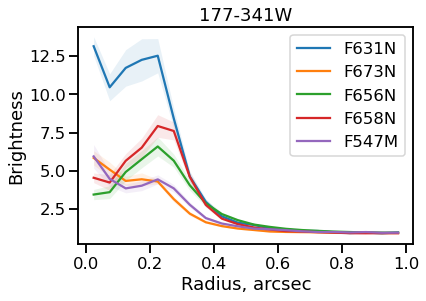

In [366]:
fig, ax = plt.subplots()
for fname in pcfilters:
    line, = ax.plot("r", fname, data=pp.mean, label=fname.upper())
    ax.fill_between(
        pp.mean["r"], 
        pp.mean[fname] - 2 * pp.sigma[fname] / np.sqrt(pp.npix[fname]), 
        pp.mean[fname] + 2 * pp.sigma[fname] / np.sqrt(pp.npix[fname]), 
        color=line.get_color(),
        alpha=0.1,
        linewidth=0,
    )
ax.legend()
ax.set_title(pp.name)
ax.set(
    xlabel="Radius, arcsec",
    ylabel="Brightness",
)
...;

## Isolate the 6300 emission from the neutral flow

We want to subtract two things from the raw F631N brightness:

1. The continuum emission in the filter bandpass. This is mainly direct starlight, but will include a bit of scattered starlight and bound-free atomic continuum too. 

2. The [O I] 6300 line emission that comes from the ionization front instead of from the neutral gas. This should be sharply peaked at an ionization fraction of $x = 0.5$ because of the $x (1 - x)$ dependence.

For (1) we can subtract off the broader band filter F547M.  But if we only want to subtract the star part, then we can use a scaled version of Ha F656N to estimate the atomic continuum contribution. I choose a value of `atfac` so that the emission at the i-front is cancelled out. Note that this ignores the fact that F656N itself will have a small continuum contribution. *This does not work very well – I am going to try to calculate it better*

For (2), we can just subtract the Ha F656N profile. This will over-correct for fully ionized part of the proplyd flow, which might lead to negative parts of the profile. 

### Pilot study of 177-341W

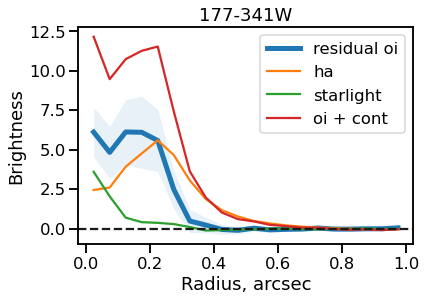

In [367]:
atfac = 0.55
cont = pp.mean["f547m"] - atfac * (pp.mean["f656n"] - 1)
oin = pp.mean["f631n"] - (cont - 1) - (pp.mean["f656n"] - 1)
sig = np.sqrt(
    pp.sigma["f547m"]**2 / pp.npix["f547m"] 
    + pp.sigma["f631n"]**2 / pp.npix["f631n"] 
    + pp.sigma["f656n"]**2 / pp.npix["f656n"]
)


fig, ax = plt.subplots()
line, = ax.plot(pp.mean["r"], oin - 1, label="residual oi", linewidth=5)
ax.fill_between(
    pp.mean["r"], 
    (oin - 1) - 3 * sig, 
    (oin - 1) + 3 * sig, 
    color=line.get_color(),
    alpha=0.1,
    linewidth=0,
)
ax.plot(pp.mean["r"], pp.mean["f656n"] - 1, label="ha")
ax.plot(pp.mean["r"], cont - 1, label="starlight")
ax.plot(pp.mean["r"], pp.mean["f631n"] - 1, label="oi + cont")

ax.axhline(0.0, linestyle="dashed", color="k")
ax.legend()
ax.set_title(pp.name)
ax.set(
    xlabel="Radius, arcsec",
    ylabel="Brightness",
)
...;

### Extracting the profile of stellar continuum

What I will try and do is to assume that beyond a certain point (say 0.2 arcsec) all the continuum is atomic and therefore proportional to Ha.  So I will calculate the average F547M/F656N in that range and use it as my `atfac` to help isolate the stellar peak at the origin.

In [368]:
def find_atomic_factor(pp: ProplydProfiles, rstar=0.2):
    m = pp.r >= rstar
    f547m = np.sum(pp.mean["f547m"][m] - 1)
    f656n = np.sum(pp.mean["f656n"][m] - 1)
    return f547m / f656n

In [369]:
pp = ProplydProfiles(source_table.loc["180-331"], pcfilters)
find_atomic_factor(pp)

0.41433364806186246

For some of the sources, this does not give a reasonable value (which I am defining as between 0.2 and 1.0), so for those I will just assume 0.5.

### Isolated 6300 profile for all sources

Make lists of sources that  are particularly weak or particularly strong, since we will need to change the plot limits for those.

In [370]:
weak_sources = [
    "156-308 NEW", "174-414", "183-427", "183-419", "182-413", 
    "175-355", "152-319", "154-321 NEW", "154-324", "179-354",
    "182-316", "169-338", "170-360 NEW",
]
bright_sources = ["167-317", "163-317", "158-323", "171-340", "176-325"]

In [371]:
class ProplydResults:
    """Final results extracted from filter images"""
    def __init__(self, pp: ProplydProfiles):
        self.r = pp.r
        # Left edge of bins to improve plotting
        self.rleft = pp.r - pp.bin_size / 2
        self.pp = pp
        
        # Total profile in F631N filter
        self.f631n = pp.mean["f631n"]
        # Ignore potential contamination of Ha filter for now
        self.ha = pp.mean["f656n"]
        # Profiles of stellar continuum: subtract atomic cont from F547M
        self.atfac = find_atomic_factor(pp)
        if not (0.2 < self.atfac < 1.0):
            self.atfac = 0.5
        self.cont = pp.mean["f547m"] - self.atfac * (self.ha - 1)
        # Do not let it go below BG 
        self.cont = np.maximum(self.cont, 1.0)
        # [O I] 6300 emission with continuum and i-front removed
        self.oin = self.f631n - (self.cont - 1) - (self.ha - 1)
        # Assume all the errors can be added in quadrature
        self.sig = np.sqrt(
            pp.sigma["f547m"]**2 / pp.npix["f547m"] 
            + pp.sigma["f631n"]**2 / pp.npix["f631n"] 
            + pp.sigma["f656n"]**2 / pp.npix["f656n"]
        )
         


Make plots of the profiles for each source. 

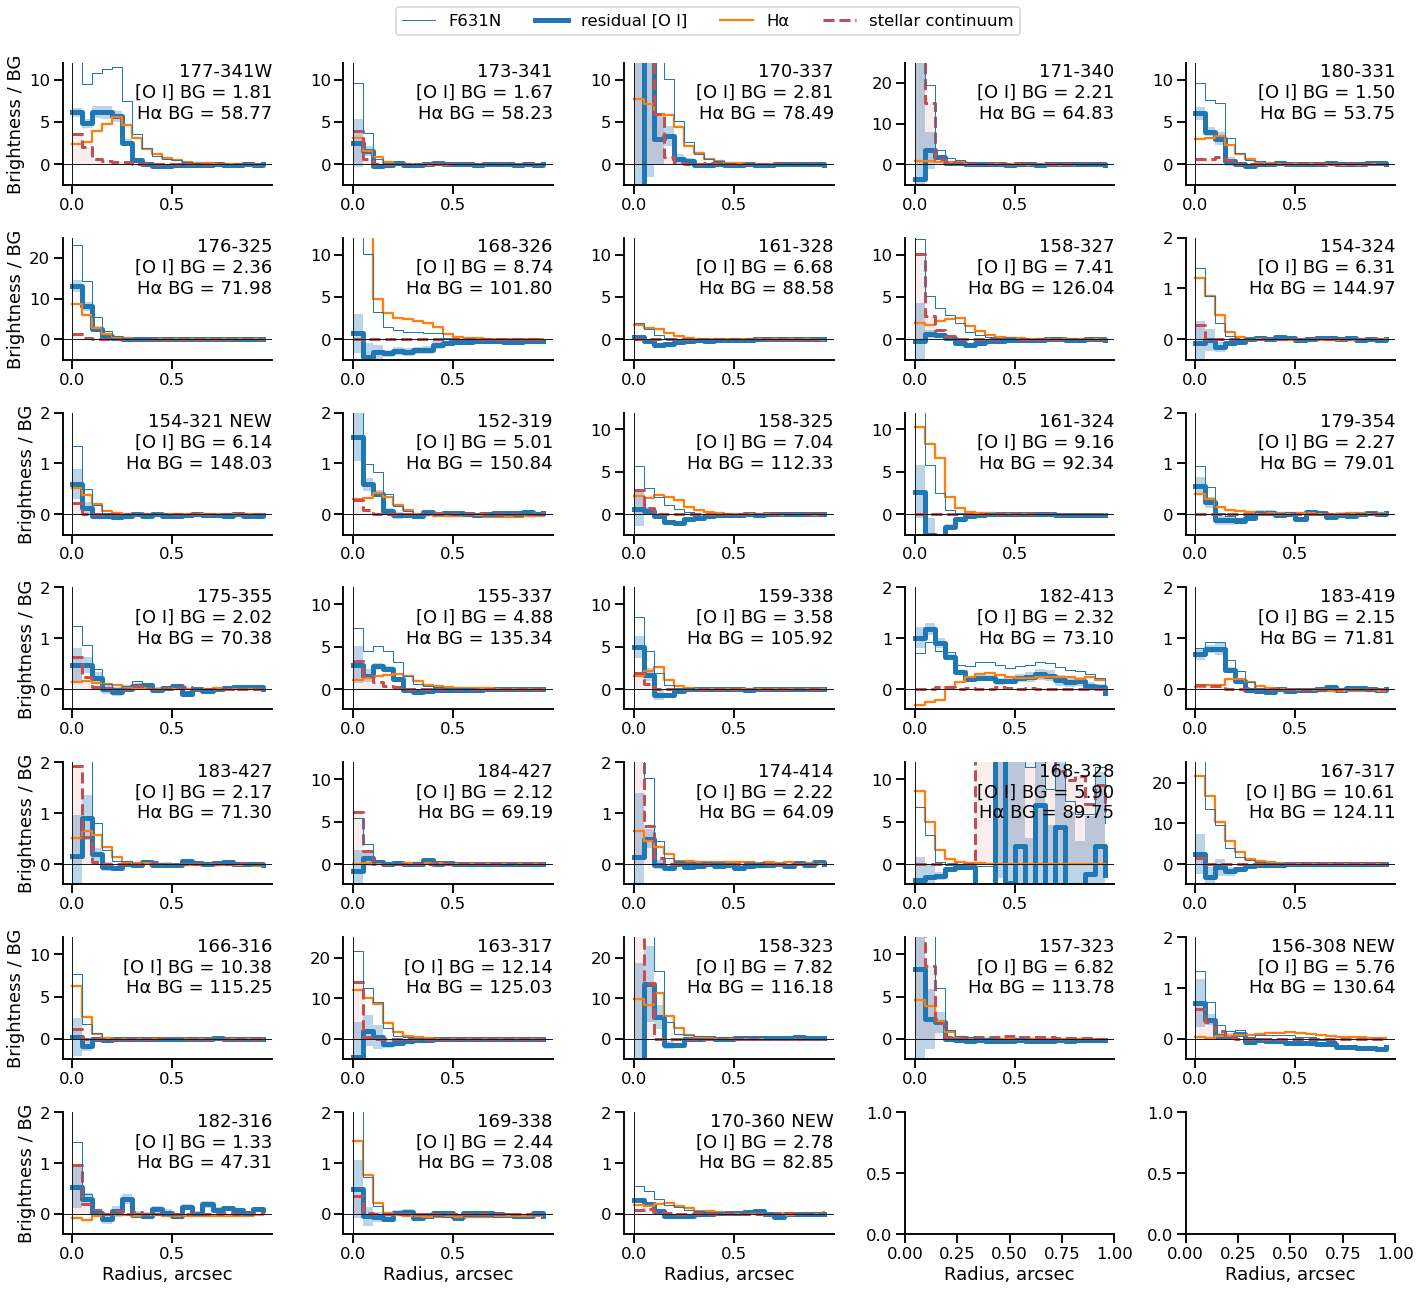

In [372]:
ncols = 5
nrows = 1 + nprops // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 2.5 * nrows))

for ax, row in zip(axes.flat, source_table):
    pp = ProplydProfiles(row, pcfilters)
    pres = ProplydResults(pp)
    
    oiline, = ax.plot(
        pres.rleft, pres.oin - 1, 
        label="residual [O I]", linewidth=5,
        drawstyle="steps-post",
    )
    ax.fill_between(
        pres.rleft, 
        (pres.oin - 1) - 1 * pres.sig, 
        (pres.oin - 1) + 1 * pres.sig, 
        color=oiline.get_color(),
        alpha=0.3,
        linewidth=0,
        step="post",
    )
    haline, = ax.plot(
        pres.rleft, pres.ha - 1, 
        label="Hα",
        drawstyle="steps-post",
    )
    cline, = ax.plot(
        pres.rleft, pres.cont - 1, 
        label="stellar continuum",         
        drawstyle="steps-post",
        color="r",
        linestyle="dashed",
        linewidth=3,
    )
    ax.fill_between(
        pres.rleft, 
        0.0, 
        pres.cont - 1, 
        color=cline.get_color(),
        alpha=0.1,
        linewidth=0,
        step="post",
    )
    oiline2, = ax.plot(
        pres.rleft, pres.f631n - 1, 
        label="F631N",         
        drawstyle="steps-post",
        color=oiline.get_color(),
        linewidth=1,
    )

    #ax.plot(pp.mean["r"], pp.mean["f631n"] - 1, label="oi + cont")

    ax.axhline(0.0, linewidth=1, color="k")
    ax.axvline(0.0, linewidth=1, color="k")

    
    #ax.legend()
    label = row['Name']
    label += "\n" + f"[O I] BG = {pp.bgmean['f631n']:.2f}"
    label += "\n" + f"Hα BG = {pp.bgmean['f656n']:.2f}"

    ax.text(1.0, 1.0, label, transform=ax.transAxes, va="top", ha="right")
    if row['Name'] in weak_sources:
        yscale = 2.0
    elif row['Name'] in bright_sources:
        yscale = 25.0
    else:
        yscale = 12.0
    ax.set(ylim=[-yscale / 5, yscale])


for ax in axes[-1, :]:
    ax.set(xlabel="Radius, arcsec")
for ax in axes[:, 0]:
    ax.set(ylabel="Brightness / BG")

fig.legend(
    handles=[oiline2, oiline, haline, cline], 
    ncol=4, 
    loc="lower center",
    bbox_to_anchor=(0.5, 1.0),
)

sns.despine()
fig.tight_layout()
...;

## Calculate the final fluxes for each proplyd

We can sum the radial brightness profile multiplied by the number of pixels that contributed to each radial bin. This will give us the total flux in detector units (we still need to do the absolute flux callibration afterwards). We do this for three profiles: Hα, neutral [O I], and stellar continuum. 

We will also calculate the mean brightness-weighted radius of each profile. 

There are a few details that we need to consider: masking and errors/upper limits.  For Hα we mask out bins that have brightness below the BG value. This is so that we are not affected by the shadow disks, which would give negative brightness after BG subtraction. This mainly only effects 182-413.

For [O I] we only include radii up to the 1.5 times the mean radius in Hα so that we are not affected by noise or unrelated emission at larger radii. We also only include bins where the residual oi emission exceeds the BG value. We do separate calculations (with separate masks) for the central value and for +/- 1 sigma. In some cases there will be no bins where _mean minus sigma_ exceeds the BG, so we count these as non-detections, but we still have upper limits from the _mean plus sigma_. I do not do any reduction of the sigma from averaging multiple bins since the uncertainties are systematic, at least in part. (Although this means that we are probably overestimating the error bars for the larger proplyds).

In [373]:
def calculate_fluxes(pr: ProplydResults):
    """Sum the brightness profiles to get fluxes
    
    Mutates the ProplydResults object by adding new fields
    """

    # Only bins with Ha greater than 1.1 x BG to avoid shadow disks and spurious stuff
    mha = pr.ha >= 1.1
    # Total BG-subtracted flux in detector units DN/s 
    pr.flux_ha = np.sum(
        ((pr.ha - 1) * pr.pp.npix["f656n"])[mha]
    ) * pr.pp.bgmean['f656n']
    # Mean radius of the Ha emission
    try:
        pr.r_ha = np.average(pr.r[mha], weights=(pr.ha[mha] - 1))
    except ZeroDivisionError:
        # Case where mask is all false
        pr.r_ha = np.nan
    
        
    # Only bins with oi greater than BG 
    # and only radii up to a certain factor times the mean Ha radius
    rfac = 1.5
    moi = (pr.oin >= 1.0) & (pr.r < rfac * pr.r_ha)
    
    # Same but plus or minus sigma
    moi_hi = (pr.oin + pr.sig >= 1.0) & (pr.r < rfac * pr.r_ha)
    moi_lo = (pr.oin - pr.sig >= 1.0) & (pr.r < rfac * pr.r_ha)
    
    pr.flux_oi = np.sum(
        ((pr.oin - 1) * pr.pp.npix["f631n"])[moi]
    ) * pr.pp.bgmean['f631n']
    try:
        pr.r_oi = np.average(pr.r[moi], weights=(pr.oin[moi] - 1))
    except ZeroDivisionError:
        # Case where mask is all false
        pr.r_oi = np.nan

    # Upper limit
    pr.flux_oi_hi = np.sum(
        ((pr.oin - 1 + pr.sig) * pr.pp.npix["f631n"])[moi_hi]
    ) * pr.pp.bgmean['f631n']
    # Lower limit
    pr.flux_oi_lo = np.sum(
        ((pr.oin - 1 - pr.sig) * pr.pp.npix["f631n"])[moi_lo]
    ) * pr.pp.bgmean['f631n']

    # Repeat for the stellar continuum
    mcont = (pr.cont >= 1.0) & (pr.r < rfac * pr.r_ha)
    pr.flux_cont = np.sum(
        ((pr.cont - 1) * pr.pp.npix["f547m"])[mcont]
    ) * pr.pp.bgmean['f547m']
    try:
        pr.r_cont = np.average(pr.r[mcont], weights=(pr.cont[mcont] - 1))
    except ZeroDivisionError:
        # Case where mask is all false
        pr.r_cont = np.nan

    # Save number of bins that contribute to each measurement
    pr.nha = np.sum(mha)
    pr.noi = np.sum(moi)
    pr.noi_lo = np.sum(moi_lo)
    pr.noi_hi = np.sum(moi_hi)
    pr.ncont = np.sum(mcont)
    
    return pr


Test it out for a few of the proplyds

In [374]:
pres = calculate_fluxes(
    ProplydResults(
        ProplydProfiles(source_table[27], pcfilters)
    )
)

In [375]:
pres.r_ha, pres.r_cont, pres.r_oi

(0.11466957800638891, 0.034646560678431255, 0.08937959934115616)

In [376]:
pres.flux_ha, pres.flux_cont, pres.flux_oi, pres.flux_oi_lo, pres.flux_oi_hi 

(46857.213558508265,
 8264.10215248107,
 1586.6054936376324,
 559.287451120067,
 3195.4929712539747)

In [377]:
pres.nha, pres.noi, pres.noi_lo, pres.noi_hi, pres.ncont

(10, 2, 2, 3, 3)

OK, that seems to be working more or less as designed.

## Table of final results

In [378]:
results = []
for row in source_table:
    pres = calculate_fluxes(
        ProplydResults(
            ProplydProfiles(row, pcfilters)
        )
    )    
    results.append(
        {
            "Name": pres.pp.name.split()[0],
            "Sep": row["Sep"],
            "F_ha": pres.flux_ha,
            "F_oi": pres.flux_oi,
            "F_oi_lo": pres.flux_oi_lo,
            "F_oi_hi": pres.flux_oi_hi,
            "F_cont": pres.flux_cont,
            "r_ha": pres.r_ha * u.arcsec,
            "r_oi": pres.r_oi * u.arcsec,
            "r_cont": pres.r_cont * u.arcsec,
            "s/n": pres.flux_oi / (pres.flux_oi_hi - pres.flux_oi)
        }
    )
results_table = QTable(results)
results_table.add_index("Name")
for col in results_table.itercols():
    if col.info.unit == "arcsec":
        col.info.format = ".2f"
    if col.info.name.startswith("F_"):
        col.info.format = ".3g"
    if col.info.name in ["s/n"]:
        col.info.format = ".2f"

<ipython-input-378-47268c8b2139>:20: RuntimeWarning: invalid value encountered in double_scalars
  "s/n": pres.flux_oi / (pres.flux_oi_hi - pres.flux_oi)


In [379]:
results_table.info

<QTable length=33>
  name   dtype   unit  format  class   n_bad
------- ------- ------ ------ -------- -----
   Name    str8                 Column     0
    Sep float64 arcsec    .2f    Angle     0
   F_ha float64           .3g   Column     0
   F_oi float64           .3g   Column     0
F_oi_lo float64           .3g   Column     0
F_oi_hi float64           .3g   Column     0
 F_cont float64           .3g   Column     0
   r_ha float64 arcsec    .2f Quantity     1
   r_oi float64 arcsec    .2f Quantity     3
 r_cont float64 arcsec    .2f Quantity     6
    s/n float64           .2f   Column     1

In [380]:
upper_limits = results_table["F_oi_lo"] <= 0.0
results_table["F_oi"][upper_limits] = np.nan
invalid_cont = results_table["F_cont"] <= 0.0
results_table["F_cont"][invalid_cont] = np.nan

In [381]:
results_table.show_in_notebook()

idx,Name,Sep,F_ha,F_oi,F_oi_lo,F_oi_hi,F_cont,r_ha,r_oi,r_cont,s/n
,,arcsec,,,,,,arcsec,arcsec,arcsec,
0,177-341W,25.43,3.26e+04,730,633,827,283,0.23,0.14,0.07,7.53
1,173-341,22.35,2.23e+03,43.6,17.3,71.8,109,0.06,0.04,0.03,1.54
2,170-337,16.00,3.58e+04,651,86.6,1.46e+03,9.21e+03,0.14,0.10,0.04,0.81
3,171-340,18.87,3e+03,146,35.7,607,2.65e+03,0.14,0.10,0.04,0.32
4,180-331,24.70,8.13e+03,153,121,189,113,0.12,0.07,0.10,4.30
5,176-325,16.34,1.24e+04,314,274,354,68.4,0.08,0.04,0.04,7.86
6,168-326,6.45,6.06e+04,nan,0,104,nan,0.12,0.03,nan,0.30
7,161-328,7.56,4.86e+03,7.5,3.23,17,nan,0.10,0.03,nan,0.79
8,158-327,10.71,2.59e+04,93,26.5,299,1.61e+03,0.18,0.10,0.05,0.45


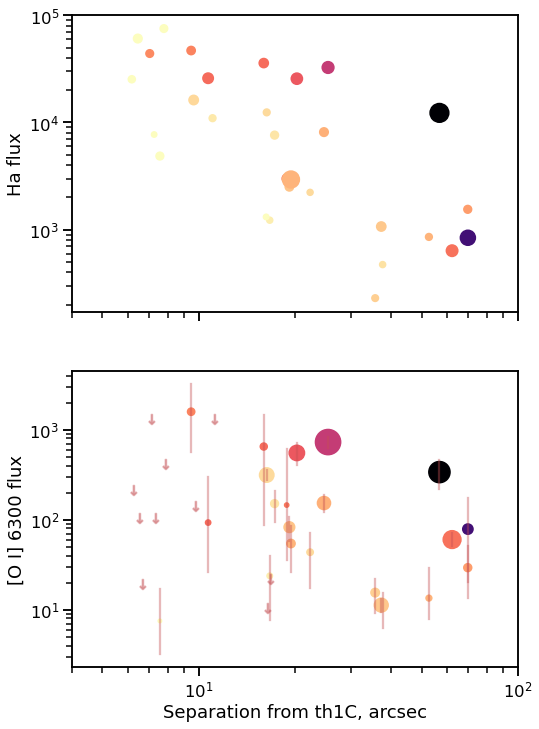

In [387]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 12))
axes[0].scatter(
    "Sep",
    "F_ha",
    data=results_table,
    s=30 * results_table["r_ha"] / 0.05,
    c="r_oi",
    cmap="magma_r",
)
axes[1].scatter(
    "Sep",
    "F_oi",
    data=results_table,
    s=30 * results_table["s/n"] * results_table["r_oi"] / 0.05,
    c="r_oi",
    cmap="magma_r",
)
for row in results_table:
    if np.isfinite(row["F_oi"]):
        axes[1].plot(
            [row["Sep"].value, row["Sep"].value],
            [row["F_oi_lo"], row["F_oi_hi"]],
            color="r",
            alpha=0.4,
        )
    else:
        axes[1].scatter(
            row["Sep"].value,
            row["F_oi_hi"],
            marker="$\downarrow$",
            color="r",
            s=100,
            alpha=0.4,
        )
for ax in axes:
    ax.set(
        xscale="log",
        yscale="log",
        xlim=[4.0, 100.0],
    )
axes[-1].set_xlabel("Separation from th1C, arcsec")
axes[0].set_ylabel("Ha flux")
axes[1].set_ylabel("[O I] 6300 flux")
...;

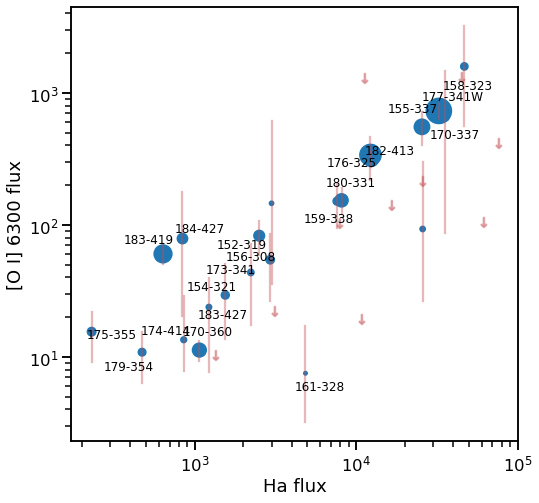

In [383]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    "F_ha",
    "F_oi",
    data=results_table,
    s=30 * results_table["s/n"] * results_table["r_oi"] / 0.05,    
)
th = 0.8
for row in results_table:
    if np.isfinite(row["F_oi"]):
        ax.plot(
            [row["F_ha"], row["F_ha"]],
            [row["F_oi_lo"], row["F_oi_hi"]],
            color="r",
            alpha=0.4,
        )
    else:
        ax.scatter(
            row["F_ha"],
            row["F_oi_hi"],
            marker="$\downarrow$",
            color="r",
            s=100,
            alpha=0.4,
        )
    if row["s/n"] > 0.5:
        ax.annotate(
            row["Name"],
            (row["F_ha"], row["F_oi"]),
            xytext=(20 * np.cos(th), 20 * np.sin(th)), 
            textcoords='offset points',
            ha="center",
            va="center",
            fontsize=12,
        )
        th += 2.2
ax.set(
    xlabel="Ha flux",
    ylabel="[O I] 6300 flux",
    xscale="log",
    yscale="log",
)
...;

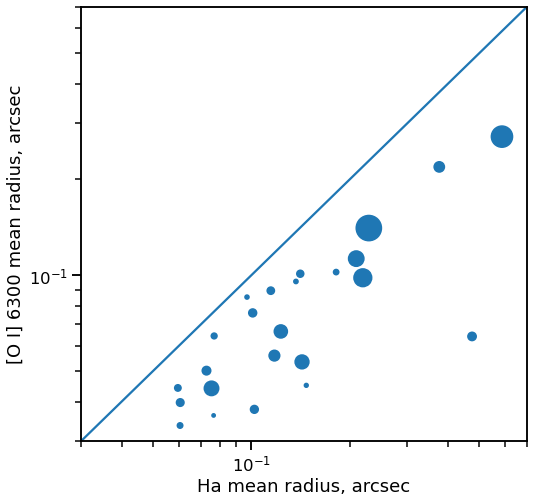

In [385]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(
    "r_ha",
    "r_oi",
    data=results_table,
    s=30 * results_table["s/n"] * results_table["r_oi"] / 0.05,    
)
ax.plot([0, 0.7], [0, 0.7])
ax.set(
    xlabel="Ha mean radius, arcsec",
    ylabel="[O I] 6300 mean radius, arcsec",
    xlim=[0.03, 0.7],
    ylim=[0.03, 0.7],
    xscale="log",
    yscale="log",
)
...;